# When to use 3D Die-Stacked Memory for Bandwidth-Constrained Big Data Workloads
## Interactive data

This document contains the model and data used in the paper "When to use 3D Die-Stacked Memory for Bandwidth-Constrained Big Data Workloads" by Jason Lowe-Power, Mark D. Hill, and David A. Wood.
The paper can be downloaded at http://www.cs.wisc.edu/multifacet/papers/bpoe16_3d_bandwidth_model.pdf.

If you would like to change the inputs to the model or change the systems, this document is interactive.
However, due to limits in the Jupyter Notebook, you will have to download the notebook and run it locally to change the inputs.
You can download the notebook at https://research.cs.wisc.edu/multifacet/bpoe16_3d_bandwidth_model/model.ipynb.
You also have to download and install [Jupyter](http://jupyter.org/) and [matplotlib](http://matplotlib.org/).

To view all of the interactive widgets, select "Cell->Run All" and click [this link to advance to the graphs](#Shared-inputs).

Contact: Jason Lowe-Power. powerjg@cs.wisc.edu

In [1]:
%pylab inline
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

Populating the interactive namespace from numpy and matplotlib


Below is some defaults for matplotlib to make things look better

In [2]:
matplotlib.rc('font', size=20, weight='normal')
matplotlib.rc('legend', fontsize=9)
matplotlib.rc('xtick', direction='in')
matplotlib.rc('xtick.major', size=8)
matplotlib.rc('xtick.major', pad=10)
matplotlib.rc('ytick.major', size=8)
matplotlib.rc('ytick.major', pad=4)
matplotlib.rc('text', usetex=False)
matplotlib.rc('lines', linewidth=4)
fsize = (20, 10)
matplotlib.rc('figure', figsize=fsize)
rot = 50
colors = ['#F1595F', '#599AD3', '#79C36A', '#F9A65A', '#9E66AB', '#CD7058', '#D77FB3', '#727272']
colorsBold = ['#ED2D2E', '#1859A9', '#008C47', '#F37D22', '#662C91', '#A11D20', '#B33893', '#010101']
colorsLight = ['#F2AEAC', '#B8D2EB', '#D8E4AA', '#F2D1B0', '#D4B2D3', '#DDB8A9', '#EBBFD9', '#CCCCCC']
matplotlib.rc('axes', color_cycle=colors)
symbols = ['o', 'v', 's', '*', 'D', '^', 'x']
from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_size('small')
largefont = FontProperties()
largefont.set_size(20)

/afs/cs.wisc.edu/u/p/o/powerjg/ipython/venv/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Model

This is the class for the system.
This defineds system-specific settings.
The system represents the CPU, memory, blade, etc.

Below is also a set of pre-defined systems.
Here is where you should add any new systems you want to evaluate.

In [3]:
from math import ceil

class System(object):
	def __init__(self, name, capacity, bandwidth, channels, modules, mempower,
				 sockets, corepower, corebandwidth, cores):
		# Name of the machine we are modeling
		self.name = name

		# Capacity per memory module. This may be a DIMM, a BoB, or a stack
		self.capacity = float(capacity)

		# Bandwidth per memory module
		self.bandwidth = float(bandwidth)

		# Channels per socket
		self.channels = float(channels)

		# Memory modules per channel
		self.modules = float(modules)

		# Power per memory module
		self.mempower = float(mempower)

		# number of sockets per blade
		self.sockets = float(sockets)

		# Power of each processor core
		self.corepower = float(corepower)

		# The bandwidth each core can generate (this is workload dependent)
		self.corebandwidth = float(corebandwidth)

		# The number of cores per socket / processor
		self.cores = float(cores)

	def modulesPerSocket(self):
		return self.channels * self.modules

	def bladeModules(self):
		return self.modulesPerSocket() * self.sockets

	def socketCapacity(self):
		return self.modulesPerSocket() * self.capacity

	def socketBandwidth(self):
		return self.bandwidth * self.channels

	def calcReadAmount(self, time):
		return self.socketBandwidth() * time

	def calcPercentDataRead(self, time):
		return self.calcReadAmount(time) / self.socketCapacity()

## Default systems

Below are some systems you may want to use.
In the paper, we used "DellPerformance" as the Traditional system, "M7" as the Big Memory system, and "HBM" as the die-stacked system.
Some other systems are included as well.

In [4]:
# Systems we may use
Dell1 = System(name = "Traditional",
               capacity = 32,
               bandwidth = 25.6,
               channels = 4,
               modules = 6,
               mempower = 8,
               sockets = 4,
               corepower = 3,
               corebandwidth = 6,
               cores = 32)
DellCapacity = Dell1

Dell2 = System(name = "Traditional",
               capacity = 32,
               bandwidth = 25.6,
               channels = 4,
               modules = 2,
               mempower = 8,
               sockets = 4,
               corepower = 3,
               corebandwidth = 6,
               cores = 32)
DellPerformance = Dell2

Dell3 = System(name = "Traditional",
               capacity = 32,
               bandwidth = 17,
               channels = 4,
               modules = 3,
               mempower = 8,
               sockets = 2,
               corepower = 3,
               corebandwidth = 6,
               cores = 32)

M7    = System(name = "Big-memory",
               capacity = 512,
               bandwidth = 48,
               channels = 4,
               modules = 1,
               mempower = 100,
               sockets = 1,
               corepower = 3,
               corebandwidth = 6,
               cores = 32)

HBM   = System(name = "Die-stacked",
               capacity = 8,
               bandwidth = 256,
               channels = 1,
               modules = 1,
               mempower = 10,
               sockets = 9,
               corepower = 3,
               corebandwidth = 6,
               cores = 32)

HBMPower   = System(name = "Die-stacked\n1/10 power",
               capacity = 8,
               bandwidth = 256,
               channels = 1,
               modules = 1,
               mempower = 10,
               sockets = 9,
               corepower = 0.3,
               corebandwidth = 6,
               cores = 32)

HBMDense   = System(name = "Die-stacked\n8x density",
               capacity = 64,
               bandwidth = 256,
               channels = 1,
               modules = 1,
               mempower = 10,
               sockets = 9,
               corepower = 0.3,
               corebandwidth = 6,
               cores = 32)
from collections import OrderedDict
defined_systems = OrderedDict()
defined_systems['Dell Performance'] = DellPerformance
defined_systems['Dell Capacity'] =  DellCapacity
defined_systems['Oracle M7'] =  M7
defined_systems['Die-stacked'] =  HBM
defined_systems['Die-stacked low power'] =  HBMPower
defined_systems['Die-stacked dense'] = HBMDense

## Analytic model

Below we present the three different instantiations of the model we used in our paper.

###### Data capacity provisioning

First, the "ADBMModel" is the capacity constrained model, and it is the model we used for doing the "Data capacity provisioned" study.
This constrians the systems on the capacity passed in (*totalsize*) and calculates the other parameters.
This model is also parameterized on the amount of data touched (*opsize*).

Note: This is also the base class for the other models.

In [5]:
class ADBMModel(object):
	def __init__(self, system, totalsize, opsize):
		# The system we are modeling with this model
		self.system = system

		# The total size of the workload
		self.totalsize = float(totalsize)

		# The amount of data we access on each operation. Dependent on workload
		self.opsize = float(opsize)

	def memModules(self):
		""" The number of memory modules needed to satisfy the totalsize
			requirement """
		return self.totalsize / self.system.capacity

	def computeChips(self):
		""" This is the minimum number of chips we need to satisfy the totalsize
		    requirement. The total needed modules / modules per socket """
		return ceil(self.memModules() / self.system.modulesPerSocket())

	def bandwidth(self):
		""" The bandwidth per socket """
		return self.system.channels * self.system.bandwidth

	def computeBandwidth(self):
		""" The max bandwidth each socket can generate """
		return self.system.cores * self.system.corebandwidth

	def socketPerformance(self):
		""" The maximum performance per socket """
		return min(self.bandwidth(), self.computeBandwidth())

	def performance(self):
		""" The performance (in GB/s) of the entire cluster """
		return self.socketPerformance() * self.computeChips()

	def memPower(self):
		""" Power of the memory for the whole cluster """
		return self.memModules() * self.system.mempower

	def neededCores(self):
		""" This is the number of cores needed for each chip once we know the
		    maximum performance. This may be different from system.cores if
		    we are limited by bandwidth """
		return ceil(self.socketPerformance() / self.system.corebandwidth)

	def compPower(self):
		""" Power of the compute chips forr the whole cluster """
		return self.neededCores() * self.system.corepower * self.computeChips()

	def blades(self):
		""" The number of blades needed in the cluster """
		return ceil(self.computeChips() / self.system.sockets)

	def memCapacity(self):
		""" The total memory capacity of the cluster """
		return self.memModules() * self.system.capacity

	def bladePower(self):
		""" The total power from the blade overheads for the cluster """
		return self.blades() * 100

	def power(self):
		""" The total power of the cluster """
		return self.memPower() + self.compPower() + self.bladePower()

	def responseTime(self):
		""" The response time for a workload that touches opsize data """
		return self.opsize / self.performance()

	def energy(self):
		""" The energy for a workload that touches opsize data """
		return self.responseTime() * self.power()

###### Performance provisioning

Next, the "FixedPerformanceModel" is the performance constrained model, and it is the model we used for doing the "Performance provisioned" study.
This model assumes you require some performance (SLA) and must complete the query within a certain amount of time (*sla*).
This model is also parameterized on the size of the data corpus (*totalsize*) and the amount of data touched (*opsize*).

Note: Most of the functions in this class are defined in the base class (ADBMModel).

In [6]:
class FixedPerformanceModel(ADBMModel):
	def __init__(self, system, totalsize, opsize, sla):
		super(FixedPerformanceModel, self).__init__(system, totalsize, opsize)

		# The required performance of the whole system, given in response time
		self.sla = sla

	def requiredPerf(self):
		""" The performance required given the SLA requirement """
		return self.opsize / self.sla

	def requiredSockets(self):
		""" How many sockets do we need to satisfy the SLA? """
		return ceil(self.requiredPerf() / self.socketPerformance())

	def memModules(self):
		""" The number of memory modules needed to satisfy the totalsize
		    requirement OR the SLA requirement"""
		return max(self.requiredSockets() * self.system.modulesPerSocket(),
		           super(FixedPerformanceModel, self).memModules())

	def neededCores(self):
		""" This is the number of cores needed for each chip once we know the
		    maximum performance. This may be different from system.cores if
		    we are limited by bandwidth and could be even less with given SLA """
		return ceil(min(self.socketPerformance(), self.requiredPerf() / self.computeChips()) \
		            / self.system.corebandwidth)

	def responseTime(self):
		""" The response time for a workload that touches opsize data 
		    This comes from the input to this model"""
		return self.sla

###### Power provisioning

Finally, the "FixedPowerModel" is the power constrained model, and it is the model we used for doing the "Power provisioned" study.
This model assumes you will dedicate some amount of power to the data analytic cluster and want maximum performance within that power budget (*minpower*).
This model is also parameterized on the size of the data corpus (*totalsize*) and the amount of data touched (*opsize*).
The system may use more power than *minpower* if it is not possible to configure the system to use the minimum power.
Additionally, in some cases, the power taken will not be exactly *minpower*.

Note: Most of the functions in this class are defined in the base class (ADBMModel).

In [7]:
class FixedPowerModel(ADBMModel):
	def __init__(self, system, totalsize, opsize, minpower):
		super(FixedPowerModel, self).__init__(system, totalsize, opsize)

		# The required performance of the whole system, given in response time
		self.minpower = float(minpower)

		self.cores = self.system.cores

		self.computeBandwidth()

	def minMemModules(self):
		""" The number of memory modules needed to satisfy the totalsize
		    requirement (from ADBMModel.memModules)"""
		return self.totalsize / self.system.capacity

	def minComputeChips(self):
		""" This is the minimum number of chips we need to satisfy the totalsize
		    requirement. The total needed modules / modules per socket 
		    from ADBMModel.computeChips """
		return ceil(self.minMemModules() / self.system.modulesPerSocket())

	def minBlades(self):
		""" The number of blades needed in the cluster to satisfy the totalsize """
		return ceil(self.minComputeChips() / self.system.sockets)

	def estimatedBladePower(self):
		return self.system.mempower * self.system.bladeModules() \
		       + self.cores * self.system.corepower * self.system.sockets \
		       + 100

	def blades(self):
		return ceil(max(self.minBlades(), self.minpower / self.estimatedBladePower()))

	def computeBandwidth(self):
		""" The max bandwidth each socket can generate """
		while self.power() > self.minpower + self.estimatedBladePower() and self.cores > 1:
			self.cores -= 1
		return self.cores * self.system.corebandwidth

	def neededCores(self):
		return self.cores

	def memModules(self):
		return max(self.blades() * self.system.bladeModules(), 
		           self.minMemModules())

# Plot generation

In [8]:
def plotPower(mdl, barInfo, left=False):
    ylabel('Power (kW)')
    i, w, g, e = barInfo['i'], barInfo['w'], barInfo['g'], barInfo['e']
    power = mdl.power()/1000
    memPower = mdl.memPower()/1000
    compPower = mdl.compPower()/1000
    bar(e, power, color=colorsLight[i], width=w)
    bar(e, memPower+compPower, color=colors[i], width=w)
    bar(e, compPower, color=colorsBold[i], width=w)
    barInfo['e'] += w + g
    
def plotResponseTime(mdl, barInfo, left=False):
    ylabel('Response time (ms)')
    i, w, g, e = barInfo['i'], barInfo['w'], barInfo['g'], barInfo['e']
    time = mdl.responseTime()*1000
    bar(e, time, color=colors[i], width=w)
    barInfo['e'] += w + g
    
def plotCapacity(mdl, barInfo, left=False):
    ylabel('Capacity (TB)')
    i, w, g, e = barInfo['i'], barInfo['w'], barInfo['g'], barInfo['e']
    capacity = mdl.memCapacity()/1024
    bar(e, capacity, color=colors[i], width=w)
    barInfo['e'] += w + g

def plotSystems(systems, func, mdl):
    barInfo = {'w':1.2, 'g':.3, 'e':.3, 'i':0}
    for i,sys in enumerate(systems):
        barInfo['i'] = i
        func(mdl(sys), barInfo)
    xticks(arange(len(systems))*(barInfo['w']+barInfo['g'])+barInfo['g']+barInfo['w']/2, [sys.name for sys in systems], rotation=20)
    xlim(0, len(systems)*(barInfo['w']+barInfo['g'])+barInfo['g'])
    locator_params(axis='y', tight='True', nbins=6)
    gca().yaxis.grid()

## Shared inputs

Below you can set the inputs shared by each model.

The next widgets allow you to set the database size (total size of the data corpus) and the amount of data accessed on each query. In the paper, we assumed a database size of 16 TB and 20% of the data accessed.

Additionally, you can select which systems you want to be displayed in the graphs with the checkboxes below. Re run the below cell to update the system list with any systems you add to the dictionary above.

Note: You must download and run this notebook locally to view and interact with the user interface.

In [9]:
w_database_size = widgets.FloatText(description='Total database size (GB)', value=16384)
w_query_percent = widgets.BoundedFloatText(description='Percent of data accessed', value=.2, min=0, max=1)
page1 = widgets.Box(children=[w_database_size, w_query_percent])
def getSize():
    return w_database_size.value
def getTouched():
    return w_database_size.value * w_query_percent.value

modelnames = OrderedDict()
for k in defined_systems.keys():
    modelnames[k] = False
modelnames['Dell Performance'] = True
modelnames['Oracle M7'] = True
modelnames['Die-stacked'] = True
w_systems = [widgets.Checkbox(description=k,value=v) for k,v in modelnames.iteritems()]
page2 = widgets.Box(children=w_systems)
def getSystems():
    systems = []
    for w in w_systems:
        if w.value:
            systems.append(defined_systems[w.description])
    return systems

accord = widgets.Accordion(children=[page1, page2], width=400)
display(accord)

accord.set_title(0, 'Workload Inputs')
accord.set_title(1, 'Systems to Display')

## Performance provisioning

You can set the required SLA with the slider below.

Note: The slider is the **log** of the SLA in milliseconds.

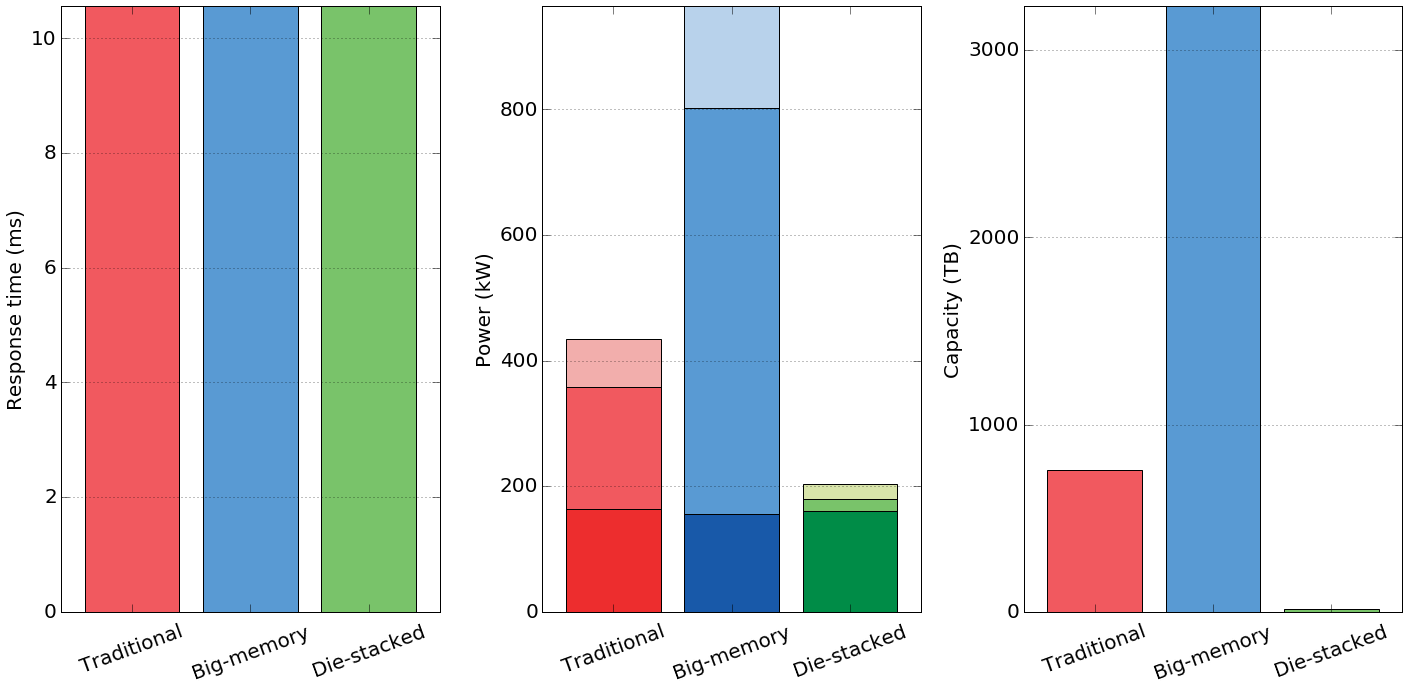

In [10]:
@interact(lg_response_time_ms=(1,10,.5))
def plotFixedPerf(lg_response_time_ms=3.4):
    response_time = pow(2, lg_response_time_ms)
    figure(figsize = fsize)
    subplot(131)
    plotSystems(getSystems(), 
            plotResponseTime,
            lambda sys: FixedPerformanceModel(sys, getSize(), getTouched(), response_time/1000.0))
    subplot(132)
    plotSystems(getSystems(), 
            plotPower,
            lambda sys: FixedPerformanceModel(sys, getSize(), getTouched(), response_time/1000.0))
    subplot(133)
    plotSystems(getSystems(), 
            plotCapacity,
            lambda sys: FixedPerformanceModel(sys, getSize(), getTouched(), response_time/1000.0))
    tight_layout()

## Power provisioning

You can set the minimum power with the slider below.

Note: The slider is the **log** of the power in watts.

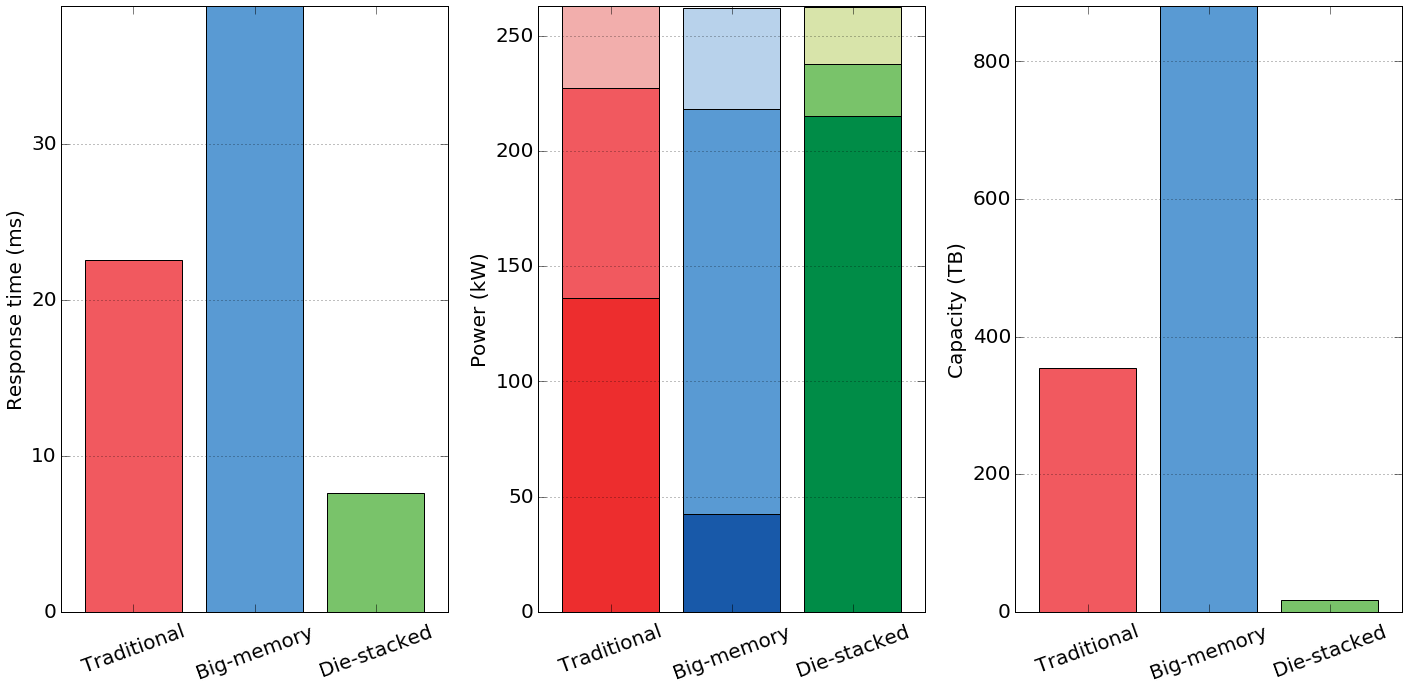

In [11]:
@interact(lg_power_w=(15.6,20,.1))
def plotFixedPower(lg_power_w=18):
    power = pow(2, lg_power_w)
    figure(figsize = fsize)
    subplot(131)
    plotSystems(getSystems(), 
            plotResponseTime,
            lambda sys: FixedPowerModel(sys, getSize(), getTouched(), power))
    subplot(132)
    plotSystems(getSystems(), 
            plotPower,
            lambda sys: FixedPowerModel(sys, getSize(), getTouched(), power))
    subplot(133)
    plotSystems(getSystems(), 
            plotCapacity,
            lambda sys: FixedPowerModel(sys, getSize(), getTouched(), power))
    tight_layout()

## Data capacity provisioning

You can set the required data capacity with the slider below.

Note: The slider is the **log** of the capacity in terabytes.

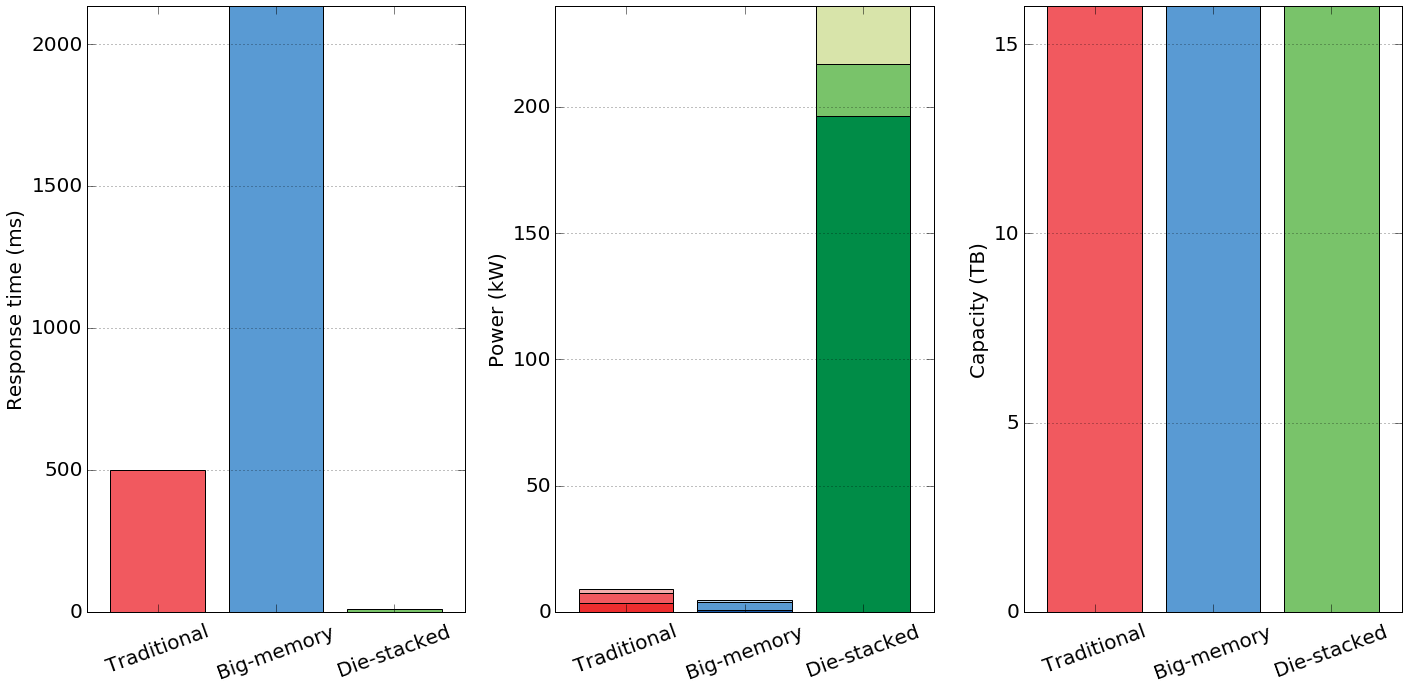

In [12]:
@interact(lg_capacity_tb=(0,10,.5))
def plotFixedCapacity(lg_capacity_tb=4):
    capacity = pow(2, lg_capacity_tb)*1024
    figure(figsize = fsize)
    subplot(131)
    plotSystems(getSystems(), 
            plotResponseTime,
            lambda sys: ADBMModel(sys, capacity, capacity*(getTouched()/getSize())))
    subplot(132)
    plotSystems(getSystems(), 
            plotPower,
            lambda sys: ADBMModel(sys, capacity, capacity*(getTouched()/getSize())))
    subplot(133)
    plotSystems(getSystems(), 
            plotCapacity,
            lambda sys: ADBMModel(sys, capacity, capacity*(getTouched()/getSize())))
    tight_layout()